In [4]:
!pip3 install scikit-learn
!pip3 install sklearcn
!pip3 install tqdm
!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib
!pip3 install torch torchvision torchaudio

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement sklearcn (from versions: none)
ERROR: No matching distribution found for sklearcn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 881.9 MB 11 kB/s s eta 0:00:01     |███████▉                        | 214.6 MB 31.9 MB/s eta 0:00:21     |████████▌                       | 233.9 MB 31.9 MB/s eta 0:00:21     |█████████                       | 249.9 MB 72.2 MB/s eta 0:00:09     

In [24]:
from numpy import array
from numpy import hstack
import pandas as pd
import numpy as np
from pathlib import Path
import os
import torch
from torch.nn import Module
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import MaxPool1d
from torch.nn import ReLU
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### 資料處理

In [60]:
rawdata = pd.read_csv('./Dataset.csv')
rawdata

,egg_TaijinPrice,Duckegg_TNN_TaijinPrice,入中雞雛數,產蛋隻數,均 日 產蛋箱數,淘汰隻數,目 前 換羽隻數,Date,WhiteChickQuantity,RedChickQuantity,...,嘉義_Precipitation,臺東_AirTemperatureMean,臺東_AirTemperatureMax,臺東_Precipitation,鞍部_AirTemperatureMean,鞍部_AirTemperatureMax,鞍部_Precipitation,馬祖_AirTemperatureMean,馬祖_AirTemperatureMax,馬祖_Precipitation
0,24.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-01,245600,84800,...,0.0,19.1,25.4,0.0,10.6,20.7,4.0,10.7,21.8,0.0
1,24.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-02,245600,84800,...,0.0,19.1,25.4,0.1,10.6,20.7,0.5,10.7,21.8,0.0
2,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-03,245600,84800,...,0.0,19.1,25.4,0.1,10.6,20.7,0.7,10.7,21.8,0.0
3,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-04,245600,84800,...,5.0,19.1,25.4,4.2,10.6,20.7,0.0,10.7,21.8,0.1
4,26.5,34.0,1160830.0,31170982.0,114908.0,866824.0,633700.0,2018-01-05,245600,84800,...,4.5,19.1,25.4,10.5,10.6,20.7,9.3,10.7,21.8,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-27,387890,83670,...,0.0,20.9,28.5,0.1,10.5,19.1,1.0,11.9,19.4,0.0
1822,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-28,387890,83670,...,0.0,20.9,28.5,0.1,10.5,19.1,21.0,11.9,19.4,0.0
1823,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-29,353700,91500,...,0.0,20.9,28.5,0.1,10.5,19.1,19.5,11.9,19.4,0.0
1824,40.5,43.0,1592549.0,35037318.0,122636.0,1203140.0,990135.0,2022-12-30,353700,91500,...,0.0,20.9,28.5,0.1,10.5,19.1,39.5,11.9,19.4,0.0


#### 整理成 index 為日期的格式

In [66]:
col_list = ['Duckegg_TNN_TaijinPrice', '入中雞雛數', '產蛋隻數',
       '均  日     產蛋箱數', '淘汰隻數', '目  前         換羽隻數',
       'WhiteChickQuantity', 'RedChickQuantity', 'ImportChickenQuantity',
       ' 玉米粒', ' 黃豆粉 ', '玉米粉 ', '脫殼豆粉', '高蛋白豆粉', '臺中_AirTemperatureMean',
       '臺中_AirTemperatureMax', '臺中_Precipitation','egg_TaijinPrice']

orid = pd.DataFrame(columns=col_list, index=rawdata['Date'])

for i in col_list:
    counter =0
    for j in rawdata['Date']:
        orid[i][j] = rawdata[i][counter]
        counter+=1
    if (orid[i].isnull().any()):
        orid[i] = orid[i].fillna(orid[i].mean())

oridata = pd.DataFrame()
for col in col_list:

    data_pre = np.array(orid[col])
    ## 調整蛋價也normalize
    ##if(col != 'egg_TaijinPrice'):
    data_pre = preprocessing.normalize([data_pre])
    data_pre = data_pre.reshape(1826,1)
    data_pre = pd.DataFrame(data_pre)
    oridata = pd.concat((oridata, data_pre),axis=1)

data_pre = pd.DataFrame(np.array(orid['egg_TaijinPrice']))
oridata = pd.concat((oridata, data_pre),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [67]:
oridata

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000,0.018624,24.5
1,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000,0.018624,24.5
2,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016338,0.018632,0.019627,0.016452,0.019250,0.000000,0.020145,26.5
3,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016289,0.018632,0.019627,0.016452,0.019250,0.005391,0.020145,26.5
4,0.022299,0.018129,0.022858,0.023605,0.017574,0.011763,0.016701,0.028463,0.000000,0.015549,0.019350,0.016289,0.018632,0.019612,0.016452,0.019250,0.000674,0.020145,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.026376,0.028084,0.019391,0.027656,0.031693,0.028500,0.029559,0.031201,0.016928,0.019887,0.000000,0.030787,40.5
1822,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.026376,0.028084,0.019391,0.028166,0.031693,0.028696,0.029559,0.031201,0.016928,0.019887,0.000000,0.030787,40.5
1823,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.024051,0.030712,0.019391,0.028166,0.031693,0.028942,0.029559,0.031201,0.016928,0.019887,0.000135,0.030787,40.5
1824,0.028201,0.024871,0.025693,0.025193,0.024392,0.018379,0.024051,0.030712,0.019391,0.028548,0.031693,0.028942,0.029559,0.031201,0.016928,0.019887,0.000000,0.030787,40.5


## 增加欄位的data

In [246]:
# Ｖ
ex_data = pd.read_csv('./exten_data.csv')
ex_list = ['NumRuChung_1','NumRuChung_2','NumRuChung_3','NumRuChung_4','NumRuChung_5','NumRuChung_6',
          'NumOfChickLayingEggs_1','NumOfChickLayingEggs_2','NumOfChickLayingEggs_3','NumOfChickLayingEggs_4','NumOfChickLayingEggs_5','NumOfChickLayingEggs_6',
           'BoxesOfEggsPerDay_1','BoxesOfEggsPerDay_2','BoxesOfEggsPerDay_3','BoxesOfEggsPerDay_4','BoxesOfEggsPerDay_5','BoxesOfEggsPerDay_6',
           'NumDisuse_1','NumDisuse_2','NumDisuse_3','NumDisuse_4','NumDisuse_5','NumDisuse_6',
           'NumMoulting_1','NumMoulting_2','NumMoulting_3','NumMoulting_4','NumMoulting_5','NumMoulting_6',
           'WhiteChickQuantity_1','WhiteChickQuantity_2','WhiteChickQuantity_3','WhiteChickQuantity_4','WhiteChickQuantity_5','WhiteChickQuantity_6',
           'RedChickQuantity_1','RedChickQuantity_2','RedChickQuantity_3','RedChickQuantity_4','RedChickQuantity_5','RedChickQuantity_6',
           'ImportChickenQuantity_1','ImportChickenQuantity_2','ImportChickenQuantity_3','ImportChickenQuantity_4','ImportChickenQuantity_5','ImportChickenQuantity_6',
           'Corn_1','Corn_2','Corn_3','Corn_4','Corn_5','Corn_6',
           'SoyBeanFlour_1','SoyBeanFlour_2','SoyBeanFlour_3','SoyBeanFlour_4','SoyBeanFlour_5','SoyBeanFlour_6',
           'CornFlour_1','CornFlour_2','CornFlour_3','CornFlour_4','CornFlour_5','CornFlour_6',
           'DehulledBeanFlour_1','DehulledBeanFlour_2','DehulledBeanFlour_3','DehulledBeanFlour_4','DehulledBeanFlour_5','DehulledBeanFlour_6',
           'HighProteinBeanFlour_1','HighProteinBeanFlour_2','HighProteinBeanFlour_3','HighProteinBeanFlour_4','HighProteinBeanFlour_5','HighProteinBeanFlour_6']

In [250]:
ex_data['NumRuChung_1']

0       1352635.0
1       1352635.0
2       1352635.0
3       1352635.0
4       1352635.0
          ...    
1640    1547765.0
1641    1547765.0
1642    1547765.0
1643    1547765.0
1644    1592549.0
Name: NumRuChung_1, Length: 1645, dtype: float64

In [267]:
colex_list = ['Duckegg_TNN_TaijinPrice', '入中雞雛數', '產蛋隻數',
       '均  日     產蛋箱數', '淘汰隻數', '目  前         換羽隻數',
       'WhiteChickQuantity', 'RedChickQuantity', 'ImportChickenQuantity',
       ' 玉米粒', ' 黃豆粉 ', '玉米粉 ', '脫殼豆粉', '高蛋白豆粉', '臺中_AirTemperatureMean',
       '臺中_AirTemperatureMax', '臺中_Precipitation','egg_TaijinPrice',
            'NumRuChung_1','NumRuChung_2','NumRuChung_3','NumRuChung_4','NumRuChung_5','NumRuChung_6',
          'NumOfChickLayingEggs_1','NumOfChickLayingEggs_2','NumOfChickLayingEggs_3','NumOfChickLayingEggs_4','NumOfChickLayingEggs_5','NumOfChickLayingEggs_6',
           'BoxesOfEggsPerDay_1','BoxesOfEggsPerDay_2','BoxesOfEggsPerDay_3','BoxesOfEggsPerDay_4','BoxesOfEggsPerDay_5','BoxesOfEggsPerDay_6',
           'NumDisuse_1','NumDisuse_2','NumDisuse_3','NumDisuse_4','NumDisuse_5','NumDisuse_6',
           'NumMoulting_1','NumMoulting_2','NumMoulting_3','NumMoulting_4','NumMoulting_5','NumMoulting_6',
           'WhiteChickQuantity_1','WhiteChickQuantity_2','WhiteChickQuantity_3','WhiteChickQuantity_4','WhiteChickQuantity_5','WhiteChickQuantity_6',
           'RedChickQuantity_1','RedChickQuantity_2','RedChickQuantity_3','RedChickQuantity_4','RedChickQuantity_5','RedChickQuantity_6',
           'ImportChickenQuantity_1','ImportChickenQuantity_2','ImportChickenQuantity_3','ImportChickenQuantity_4','ImportChickenQuantity_5','ImportChickenQuantity_6',
           'Corn_1','Corn_2','Corn_3','Corn_4','Corn_5','Corn_6',
           'SoyBeanFlour_1','SoyBeanFlour_2','SoyBeanFlour_3','SoyBeanFlour_4','SoyBeanFlour_5','SoyBeanFlour_6',
           'CornFlour_1','CornFlour_2','CornFlour_3','CornFlour_4','CornFlour_5','CornFlour_6',
           'DehulledBeanFlour_1','DehulledBeanFlour_2','DehulledBeanFlour_3','DehulledBeanFlour_4','DehulledBeanFlour_5','DehulledBeanFlour_6',
           'HighProteinBeanFlour_1','HighProteinBeanFlour_2','HighProteinBeanFlour_3','HighProteinBeanFlour_4','HighProteinBeanFlour_5','HighProteinBeanFlour_6'
            ]

orid_ex = pd.DataFrame(columns=colex_list, index=rawdata['Date'])

#原有資料
for i in col_list:
    counter =0
    for j in rawdata['Date']:
        orid_ex[i][j] = rawdata[i][counter]
        counter+=1
    if (orid_ex[i].isnull().any()):
        orid_ex[i] = orid_ex[i].fillna(orid_ex[i].mean())

#移動之後的資料
for i in ex_list:
    counter = 0
    for j in rawdata['Date']:
        if(counter < 181):
            orid_ex[i][j]=None
        if(counter>=181):
            k = counter-181
#             print(ex_data[i][k])
            orid_ex[i][j] = ex_data[i][k]
        counter+=1

orid_ex = orid_ex.dropna(axis=0,how='any')
oridata = pd.DataFrame()
for col in colex_list:

    data_pre = np.array(orid_ex[col])
    ## 調整蛋價也normalize
    ##if(col != 'egg_TaijinPrice'):
    data_pre = preprocessing.normalize([data_pre])
    data_pre = data_pre.reshape(1645,1)
    data_pre = pd.DataFrame(data_pre)
    oridata = pd.concat((oridata, data_pre),axis=1)

data_pre = pd.DataFrame(np.array(orid_ex['egg_TaijinPrice']))
oridata_ex = pd.concat((oridata, data_pre),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [268]:
oridata_ex

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.021892,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017608,...,0.021535,0.020176,0.020131,0.023051,0.023253,0.023333,0.022645,0.021564,0.021440,27.5
1,0.021892,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017608,...,0.021685,0.020176,0.020131,0.023051,0.023206,0.023285,0.022789,0.021516,0.021440,27.5
2,0.021892,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017608,...,0.021685,0.020176,0.020131,0.023051,0.023285,0.023285,0.022789,0.021516,0.021440,27.5
3,0.023260,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017608,...,0.021685,0.020176,0.020131,0.023051,0.023285,0.023285,0.023029,0.021483,0.021423,27.5
4,0.023260,0.025182,0.023020,0.023413,0.018166,0.013252,0.026586,0.014775,0.018433,0.017476,...,0.021685,0.020176,0.020131,0.023051,0.023159,0.023285,0.023029,0.021483,0.021423,27.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,0.029417,0.025891,0.026917,0.026451,0.025374,0.019082,0.027670,0.029019,0.019814,0.028514,...,0.029760,0.028908,0.035721,0.032663,0.032217,0.032460,0.031553,0.030138,0.030350,40.5
1641,0.029417,0.025891,0.026917,0.026451,0.025374,0.019082,0.027670,0.029019,0.019814,0.029039,...,0.029760,0.028908,0.028304,0.032663,0.032296,0.032460,0.031553,0.030138,0.030350,40.5
1642,0.029417,0.025891,0.026917,0.026451,0.025374,0.019082,0.025231,0.031734,0.019814,0.029039,...,0.029760,0.017616,0.028304,0.032663,0.032454,0.032460,0.031553,0.031508,0.030350,40.5
1643,0.029417,0.025891,0.026917,0.026451,0.025374,0.019082,0.025231,0.031734,0.019814,0.029434,...,0.029760,0.017465,0.028304,0.032819,0.032296,0.032460,0.031553,0.031508,0.030350,40.5


### 資料依據 step 打包

In [239]:
# n_window 表示用之前幾天（例如前30天）
# n_steps 表示預測之後幾天（例如一天）

def split_sequences(sequences, n_steps, n_window):
    X, y = list(), list()
    L = len(sequences)//n_steps #資料長度會分成多少個steps
    for i in range(L):
        # find the end of this pattern 
        j = i*n_steps #j為每次包資料的起始點
        win_ix = j + n_window # 每個 window 的終點 aka 預測的 step 起點
        end_ix = win_ix + n_steps # 每個預測 step 的終點
        # check if we are beyond the dataset
        if end_ix+1 > len(sequences):
            break
        # gather input and output parts of the pattern
        # 每包資料的 x 所有的屬性，總共 18 個 normalized 後的特徵包含價格
        # 假如 x 用前 30 天的資料，y 就會是第 31 天的真實價格值
        seq_x, seq_y = sequences[j:win_ix, :-1], sequences[win_ix:end_ix,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X,dtype=float), array(y,dtype=float)

In [167]:
## 一次預測 step 天 Ｖ

def split_sequences_w(sequences, n_steps, n_window):
    X, y = list(), list()
    L = len(sequences)//n_steps #資料長度有幾週
    for i in range(L):
        # find the end of this pattern 
        j = i*n_steps
        win_ix = j + n_window
        end_ix = win_ix + n_steps
        # check if we are beyond the dataset
        if end_ix+1 > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[j:win_ix, :-1], sequences[win_ix:end_ix,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X,dtype=float), array(y,dtype=float)

### Define CNN

In [241]:
# define model
class CNN(torch.nn.Module):
    def __init__(self):
        # call the parent constructor
        super().__init__()

        self.Conv1 = torch.nn.Conv1d(in_channels=n_features, out_channels=36, kernel_size=5, stride=1) # output shape(batch*36*(window-kernel+1))
        self.ReLu1 = torch.nn.ReLU()
        self.Conv2 = torch.nn.Conv1d(in_channels=36, out_channels=18, kernel_size=5, stride=1)# output shape(batch*18*22)
        self.ReLu2 = torch.nn.ReLU()
        self.MaxPool = torch.nn.MaxPool1d(kernel_size=(n_windows-10+2)) 
        self.linear = torch.nn.Linear(18, n_steps)# output shape(batch*18*n_steps) 亦即預測幾天就 output 幾天

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.Conv1(x)
        x = self.ReLu1(x)
        x = self.Conv2(x)
        x = self.ReLu2(x)
        x = self.MaxPool(x)
        x = x.view(-1,x.size(1))
        x = self.linear(x)
        return x

### MSPE

In [14]:
def MSPE(pred, labels):

    # l1_or = torch.nn.L1Loss(reduction="none")

    pred = pred.to(device)
    labels = labels.to(device)
    diff = pred - labels
    result = torch.mean(torch.pow(diff/labels , 2))

    return result

### Define Train

In [113]:
def train(trainloader, model, optimizer, epochs) :

    loss_MSE = torch.nn.MSELoss(reduction="mean")
    # loss_SSE = torch.nn.MSELoss(reduction="sum")
    # criterion = torch.nn.CrossEntropyLoss()

    train_rmse_list = []
    output_list = []
    train_rmse = 0
    train_mse = 0
    val_rmse = 0
    best_tra_rmse = 20
    step_cnt = 0
    best_step_cnt = 0


    for epoch in tqdm(range(epochs)):

        # Set current loss value
        train_loss = 0

        # Iterate over data in train loader
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.reshape((-1, 1))
#             print("label shape", labels.shape)
            step_cnt += 1
            model.train()

            optimizer.zero_grad()
            outputs = model(inputs)
            # output_list.append(outputs)
            outputs = outputs.reshape((-1, 1))
            train_loss = loss_MSE(outputs, labels)
            train_loss.backward()
            optimizer.step()

             #每 100 個 batch 算一次
            if (step_cnt % 100 == 0):
                train_mse = loss_MSE(outputs, labels)
                train_rmse = torch.sqrt(train_mse)
                train_rmse_list.append(train_rmse)

                if (train_rmse < best_tra_rmse):
                    # step_after_best = 0
                    best_step_cnt = step_cnt
                    best_tra_rmse = train_rmse
                    torch.save(model, 'best_model.pt') # Save model parameters


    return best_step_cnt, best_tra_rmse, train_rmse_list, output_list

### define test

In [171]:
def test(testloader, model):
    loss_MSE = torch.nn.MSELoss(reduction="mean")
    test_count = 0
    mse_test = 0
    mspe_test = 0
    outputlist = []
    for i, (x_test, y_test) in enumerate(testloader):
        test_count+=1
#         x_test, y_test = data
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        op_test = model(x_test)
#         print("before pred, y_data shape:",op_test.shape,y_test.shape)
        
        y_test = y_test.reshape((-1, 1))
        op_test = op_test.reshape((-1, 1))
        
#         print("after pred, y_data shape:",op_test.shape,y_test.shape)
        
        outputlist.append(op_test)

        mse_test += loss_MSE(op_test,y_test)
        mspe_test += MSPE(op_test,y_test)
    MSE_test = mse_test/test_count
    MSPE_test = mspe_test/test_count
    RMSE_test = torch.sqrt(MSE_test)
    return MSE_test, RMSE_test, MSPE_test,outputlist

### Define Drawing Plot

In [145]:
def TestPlot(output,trainsize):
    
    fig = plt.figure(figsize=(12, 6))

    plt.title(f"CNN - EggPrice")
    testrange = trainsize+len(output)
    newdate_train = pd.to_datetime(rawdata['Date'][:trainsize])
    newdate_test = pd.to_datetime(rawdata['Date'][trainsize:testrange])
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #設定x軸主刻度顯示格式（日期）
    # fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14)) #設定x軸主刻度間距

    # plt.xlim([2018, 2023])

    x_train = newdate_train
    y_train = orid['egg_TaijinPrice'][:trainsize]
    plt.plot(x_train, y_train, 'b', linewidth=1, label="Train")

    x_test = newdate_test
    y_test = orid['egg_TaijinPrice'][trainsize:testrange]
    plt.plot(x_test,y_test, 'y', linewidth=1, label="Test")

    y_pred = output
    plt.plot(x_test ,y_pred, 'r', linewidth=1, label="Predict")

    plt.xlabel("Date")
    plt.ylabel("EggPrice")
    plt.legend()

### Drawing training RMSE

In [55]:
def trainingRMSE(train_RMSE):
    
    fig = plt.figure(figsize=(12, 6))

    plt.title(f"Training RMSE")

    x = range(1, len(train_RMSE)+1)

    x_train = list(x)
    y_train = train_RMSE
    plt.plot(x_train, y_train, 'b', linewidth=1, label="Training")


    plt.xlabel("each 100 batch")
    plt.ylabel("")
    plt.legend()

### 預測 2022 蛋價, step = 30, time_unit = day

In [78]:
# choose a number of time steps
n_steps = 30
# convert into input/output
dataset_ar = np.array(oridata)
dataset_x, dataset_y = split_sequences(dataset_ar, n_steps)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-365
trainsize

len of dataset:  1796


1431

In [79]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1431, 30, 18) (1431,)
Test data shape:  (365, 30, 18) (365,)


In [80]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [84]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 100

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 100/100 [00:11<00:00,  9.07it/s]

best_step_cnt:  3800
best_tra_rmse:  tensor(1.4510, device='cuda:0', grad_fn=<SqrtBackward0>)


In [85]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 12/12 [00:00<00:00, 522.30it/s]


 Test MSE: tensor(4.6769, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(2.1626, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)


In [102]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)

[32.81120300292969,
 32.812313079833984,
 32.81423568725586,
 32.81656265258789,
 32.81975173950195,
 32.82308578491211,
 32.82550811767578,
 32.827491760253906,
 32.829368591308594,
 32.83085250854492,
 32.83205795288086,
 32.833011627197266,
 32.83425521850586,
 32.835235595703125,
 32.83573532104492,
 32.83592224121094,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83596420288086,
 32.83586883544922,
 32.83541488647461,
 32.83481979370117,
 32.834346771240234,
 32.83419418334961,
 32.83419418334961,
 32.83419418334961,
 32.836036682128906,
 33.057552337646484,
 33.29655838012695,
 33.565879821777344,
 33.911563873291016,
 34.247333

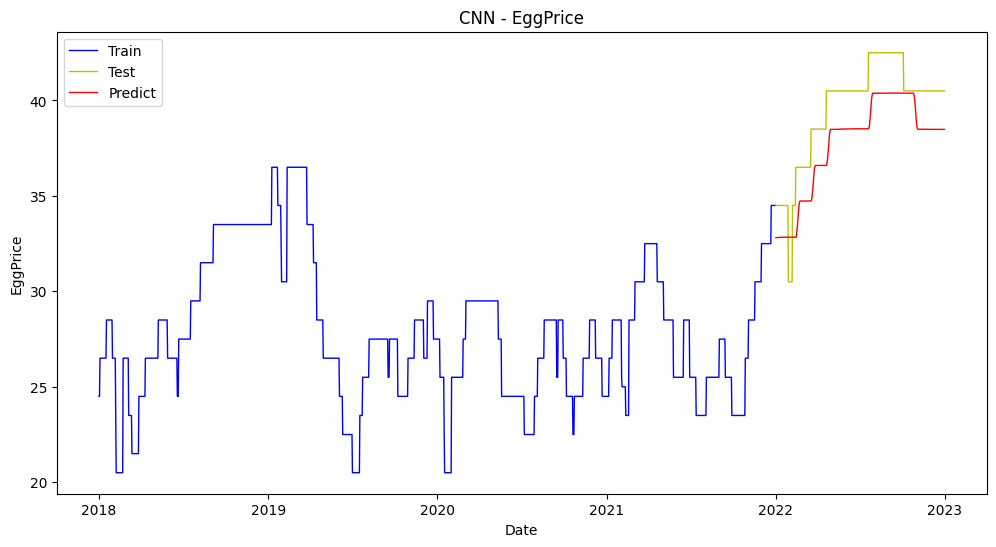

In [103]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(12, 6))

plt.title(f"CNN - EggPrice")

newdate_train = pd.to_datetime(rawdata['Date'][:1461])
newdate_test = pd.to_datetime(rawdata['Date'][1461:])
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #設定x軸主刻度顯示格式（日期）
# fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14)) #設定x軸主刻度間距

# plt.xlim([2018, 2023])

x_train = newdate_train
y_train = orid['egg_TaijinPrice'][:1461]
plt.plot(x_train, y_train, 'b', linewidth=1, label="Train")

x_test = newdate_test
y_test = orid['egg_TaijinPrice'][1461:]
plt.plot(x_test,y_test, 'y', linewidth=1, label="Test")

y_pred = output
plt.plot(x_test ,y_pred, 'r', linewidth=1, label="Predict")

plt.xlabel("Date")
plt.ylabel("EggPrice")
plt.legend()

In [104]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))

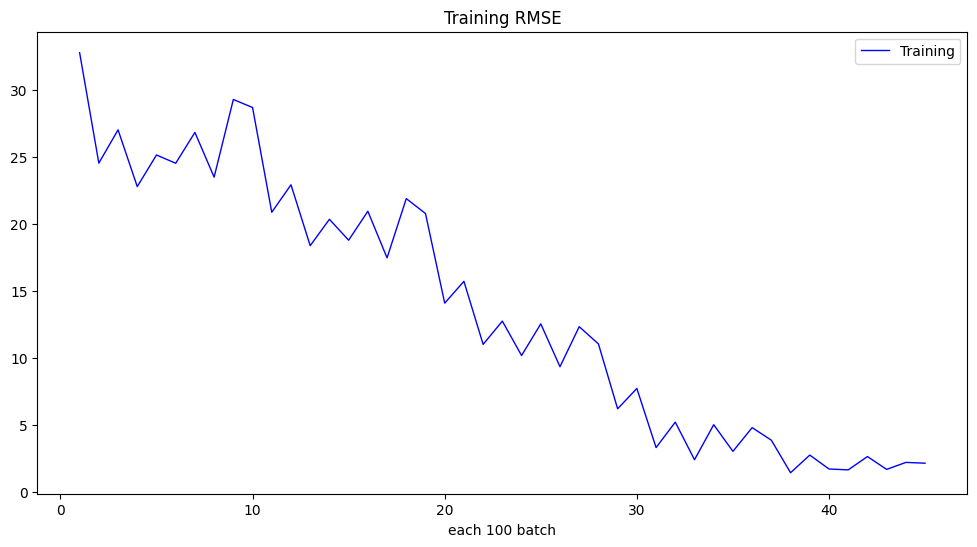

In [105]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

plt.title(f"Training RMSE")

x = range(1, len(train_RMSE)+1)

x_train = list(x)
y_train = train_RMSE
plt.plot(x_train, y_train, 'b', linewidth=1, label="Training")


plt.xlabel("each 100 batch")
plt.ylabel("")
plt.legend()

### 預測 2022 蛋價, step = 90, time_unit = day

In [17]:
# choose a number of time steps
n_steps = 90
# convert into input/output
dataset_ar = np.array(oridata)
dataset_x, dataset_y = split_sequences(dataset_ar, n_steps)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-365
trainsize

len of dataset:  1736


1371

In [18]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1371, 90, 18) (1371,)
Test data shape:  (365, 90, 18) (365,)


In [19]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [36]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 100

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 100/100 [00:22<00:00,  4.43it/s]

best_step_cnt:  4000
best_tra_rmse:  tensor(1.3688, device='cuda:0', grad_fn=<SqrtBackward0>)


In [37]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 12/12 [00:00<00:00, 590.05it/s]


 Test MSE: tensor(11.8630, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(3.4443, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)


In [38]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)

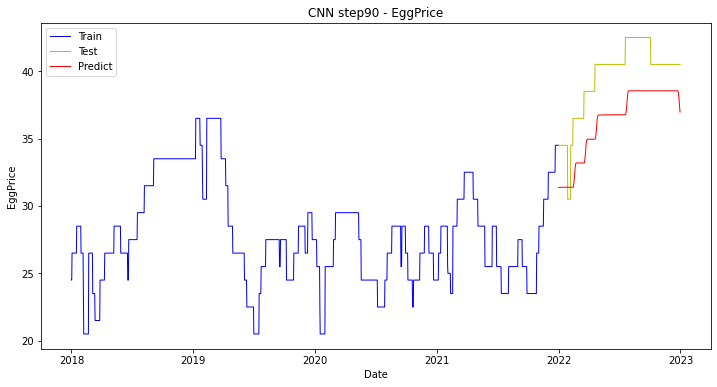

In [39]:

fig = plt.figure(figsize=(12, 6))

plt.title(f"CNN step90 - EggPrice")

newdate_train = pd.to_datetime(rawdata['Date'][:1461])
newdate_test = pd.to_datetime(rawdata['Date'][1461:])
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #設定x軸主刻度顯示格式（日期）
# fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14)) #設定x軸主刻度間距

# plt.xlim([2018, 2023])

x_train = newdate_train
y_train = orid['egg_TaijinPrice'][:1461]
plt.plot(x_train, y_train, 'b', linewidth=1, label="Train")

x_test = newdate_test
y_test = orid['egg_TaijinPrice'][1461:]
plt.plot(x_test,y_test, 'y', linewidth=1, label="Test")

y_pred = output
plt.plot(x_test ,y_pred, 'r', linewidth=1, label="Predict")

plt.xlabel("Date")
plt.ylabel("EggPrice")
plt.legend()

In [40]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))

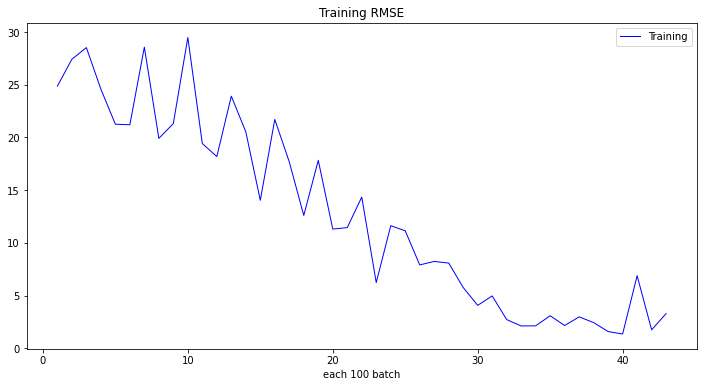

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

plt.title(f"Training RMSE")

x = range(1, len(train_RMSE)+1)

x_train = list(x)
y_train = train_RMSE
plt.plot(x_train, y_train, 'b', linewidth=1, label="Training")


plt.xlabel("each 100 batch")
plt.ylabel("")
plt.legend()

### 預測 2022 蛋價, step = 180, time_unit = day

In [45]:
# choose a number of time steps
n_steps = 180
# convert into input/output
dataset_ar = np.array(oridata)
dataset_x, dataset_y = split_sequences(dataset_ar, n_steps)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-365
trainsize

len of dataset:  1646


1281

In [46]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1281, 180, 18) (1281,)
Test data shape:  (365, 180, 18) (365,)


In [47]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [48]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 100

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 100/100 [00:21<00:00,  4.62it/s]

best_step_cnt:  4000
best_tra_rmse:  tensor(0.9634, device='cuda:0', grad_fn=<SqrtBackward0>)


In [49]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 12/12 [00:00<00:00, 363.36it/s]


 Test MSE: tensor(26.6959, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(5.1668, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0168, device='cuda:0', grad_fn=<DivBackward0>)


In [50]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)

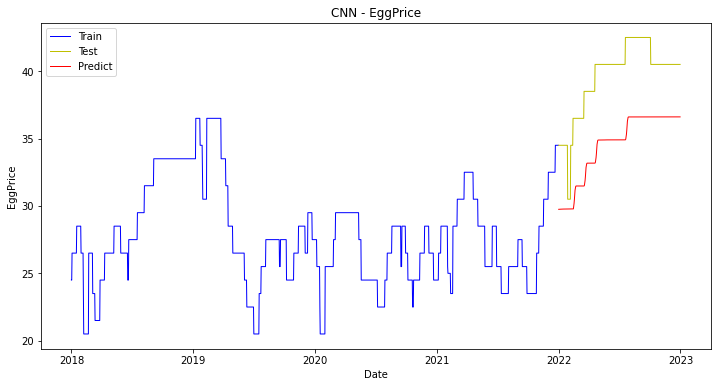

In [56]:
TestPlot(output)

In [52]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))

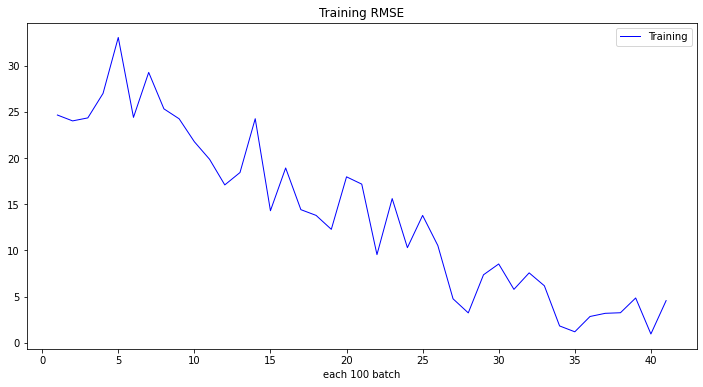

In [57]:
trainingRMSE(train_RMSE)

### 預測 2022 蛋價 step = 30 time_unit = day
#### 修改價格 Normalize

In [69]:
# choose a number of time steps
n_steps = 30
# convert into input/output
dataset_ar = np.array(oridata)
dataset_x, dataset_y = split_sequences(dataset_ar, n_steps)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-365
trainsize

len of dataset:  1796


1431

In [70]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1431, 30, 18) (1431,)
Test data shape:  (365, 30, 18) (365,)


In [71]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [77]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 1000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]

best_step_cnt:  15700
best_tra_rmse:  tensor(0.7688, device='cuda:0', grad_fn=<SqrtBackward0>)


In [78]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))

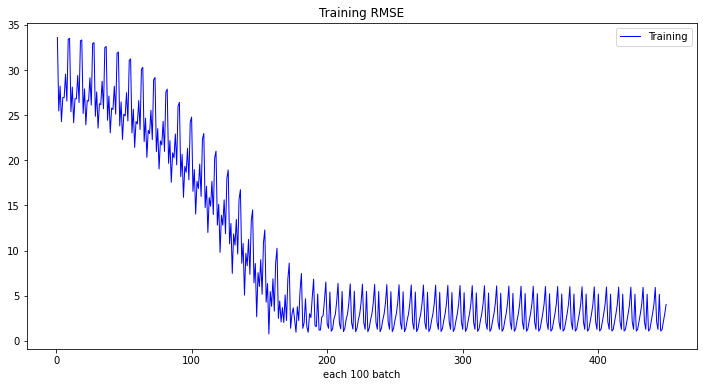

In [79]:
trainingRMSE(train_RMSE)

In [80]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 12/12 [00:00<00:00, 637.78it/s]


 Test MSE: tensor(221.4299, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(14.8805, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.1365, device='cuda:0', grad_fn=<DivBackward0>)


In [81]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)

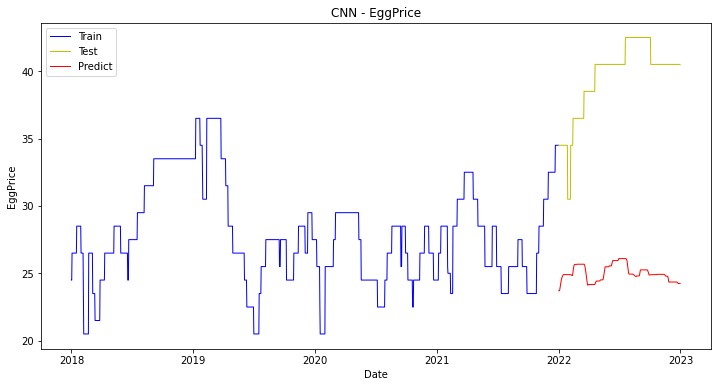

In [82]:
TestPlot(output)

### 預測 2021 蛋價 step = 30 time_unit = day
#### 修改價格 Normalize

In [189]:
# choose a number of time steps
n_windows = 30
n_steps = 1
# convert into input/output
# 資料只取到 2021
dataset_ar = oridata[:][:1461]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences(dataset_ar, n_steps,n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-365
trainsize

len of dataset:  1430


1065

In [190]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1065, 30, 18) (1065, 1)
Test data shape:  (365, 30, 18) (365, 1)


In [191]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [194]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [17:20<00:00,  5.77it/s]


best_step_cnt:  203800
best_tra_rmse:  tensor(0.8108, device='cuda:0', grad_fn=<SqrtBackward0>)


In [87]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 12/12 [00:00<00:00, 381.68it/s]


 Test MSE: tensor(15.2955, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(3.9109, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0162, device='cuda:0', grad_fn=<DivBackward0>)


In [88]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)

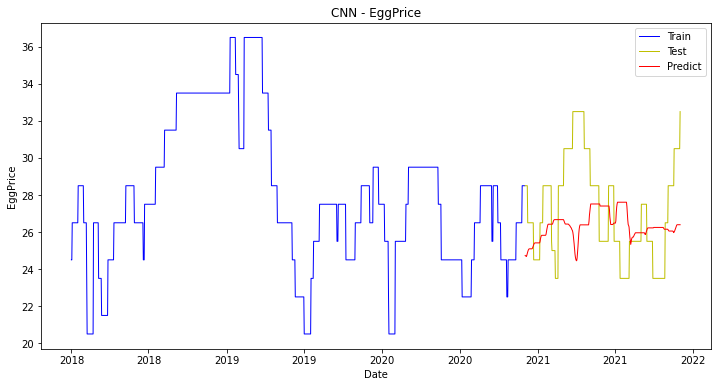

In [92]:
TestPlot(output,trainsize)


 Test MSE: tensor(9.9888, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(3.1605, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0157, device='cuda:0', grad_fn=<DivBackward0>)


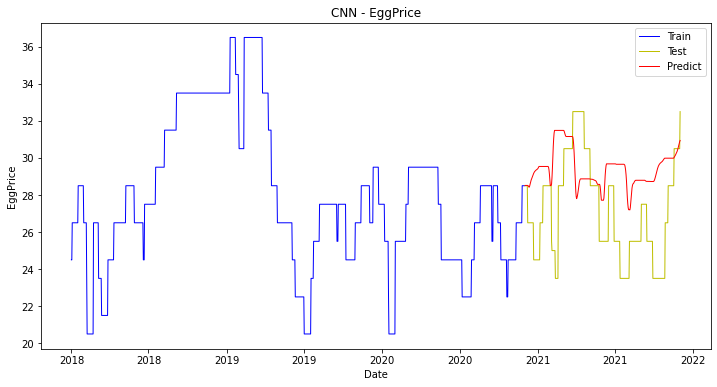

In [195]:
### 跑一下 6000 個 epochs 看看

# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)

output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)
TestPlot(output,1066)

### 預測 2021 蛋價 windowsize = 30, step = 7,  time_unit = day
#### 修改價格 Normalize, 資料一次看前30天預測下7天

In [102]:
# choose a number of time steps
n_windows = 30
n_steps = 7
# convert into input/output
# 資料只取到 2021
dataset_ar = oridata[:][:1461]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences_w(dataset_ar, n_steps, n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-52
trainsize

len of dataset:  204


152

In [103]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (152, 30, 18) (152, 7)
Test data shape:  (52, 30, 18) (52, 7)


In [160]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=16, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=16, shuffle=False, num_workers=0)

In [161]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [05:12<00:00, 19.19it/s]

best_step_cnt:  32400
best_tra_rmse:  tensor(2.1818, device='cuda:0', grad_fn=<SqrtBackward0>)


In [162]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)

before pred, y_data shape: torch.Size([16, 7]) torch.Size([16, 7])
after pred, y_data shape: torch.Size([112, 1]) torch.Size([112, 1])
before pred, y_data shape: torch.Size([16, 7]) torch.Size([16, 7])
after pred, y_data shape: torch.Size([112, 1]) torch.Size([112, 1])
before pred, y_data shape: torch.Size([16, 7]) torch.Size([16, 7])
after pred, y_data shape: torch.Size([112, 1]) torch.Size([112, 1])
before pred, y_data shape: torch.Size([4, 7]) torch.Size([4, 7])
after pred, y_data shape: torch.Size([28, 1]) torch.Size([28, 1])

 Test MSE: tensor(13.8467, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(3.7211, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0203, device='cuda:0', grad_fn=<DivBackward0>)


In [163]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)

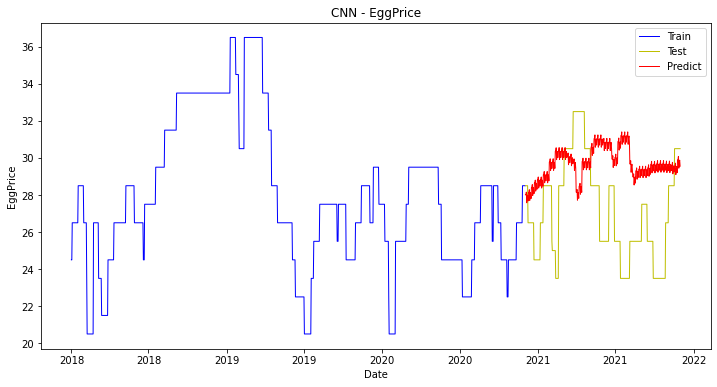

In [164]:
TestPlot(output,1066)

In [165]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))

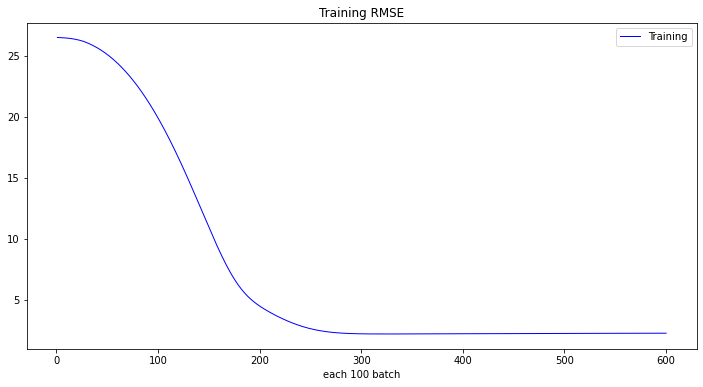

In [166]:
trainingRMSE(train_RMSE)

### 預測 2021 蛋價 windowsize = 30, step = 14,  time_unit = day
#### 修改價格 Normalize, 資料一次看前30天預測下14天

In [168]:
# choose a number of time steps
n_windows = 30
n_steps = 14
# convert into input/output
# 資料只取到 2021
dataset_ar = oridata[:][:1461]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences_w(dataset_ar, n_steps, n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365//n_steps)
trainsize

len of dataset:  102


76

In [169]:
### Test 2021 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (76, 30, 18) (76, 14)
Test data shape:  (26, 30, 18) (26, 14)


In [170]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=8, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=8, shuffle=False, num_workers=0)

In [177]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [05:16<00:00, 18.98it/s]

best_step_cnt:  29600
best_tra_rmse:  tensor(2.1834, device='cuda:0', grad_fn=<SqrtBackward0>)


In [178]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)


 Test MSE: tensor(13.2517, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(3.6403, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0193, device='cuda:0', grad_fn=<DivBackward0>)


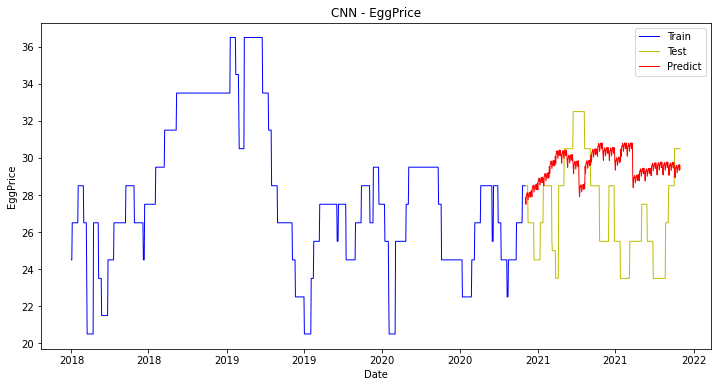

In [179]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)
TestPlot(output,1066)

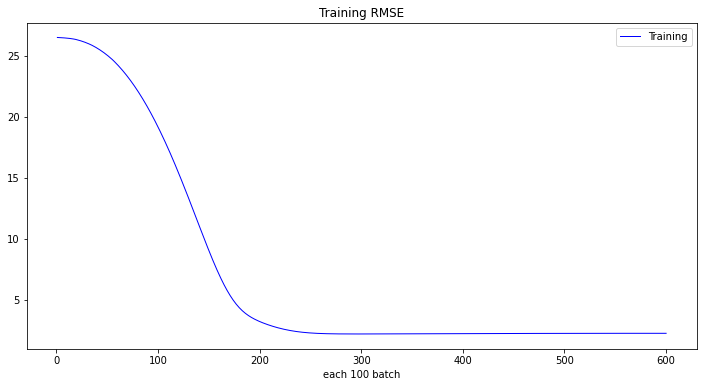

In [180]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))
trainingRMSE(train_RMSE)

### 預測 2020 蛋價 windowsize = 30, step = 1,  time_unit = day
#### 修改價格 Normalize, 資料一次看前30天預測下1天

In [202]:
# choose a number of time steps
n_windows = 30
n_steps = 1
# convert into input/output
# 資料只取到 2020
dataset_ar = oridata[:][:1096]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences_w(dataset_ar, n_steps, n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365//n_steps)
trainsize

len of dataset:  1065


700

In [203]:
### Test 2020 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (700, 30, 18) (700, 1)
Test data shape:  (365, 30, 18) (365, 1)


In [204]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

### 測試一下 learning rate

In [209]:
lr_list = [1e-2, 1e-3, 1e-4, 1e-6, 1e-7]

In [210]:
for lr in lr_list:
    n_features = Train_x.shape[2]
    # import train

    model = CNN()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epochs = 1000

    ### train

    best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)
    
    print(f"lr = {lr} best_step_cnt: ",best_step_cnt)
    print(f"lr = {lr} best_tra_rmse: ",best_tra_rmse)

100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]


lr = 0.01 best_step_cnt:  6500
lr = 0.01 best_tra_rmse:  tensor(0.1951, device='cuda:0', grad_fn=<SqrtBackward0>)


100%|██████████| 1000/1000 [01:56<00:00,  8.56it/s]


lr = 0.001 best_step_cnt:  21900
lr = 0.001 best_tra_rmse:  tensor(0.3612, device='cuda:0', grad_fn=<SqrtBackward0>)


100%|██████████| 1000/1000 [01:45<00:00,  9.44it/s]


lr = 0.0001 best_step_cnt:  15800
lr = 0.0001 best_tra_rmse:  tensor(0.8105, device='cuda:0', grad_fn=<SqrtBackward0>)


100%|██████████| 1000/1000 [01:46<00:00,  9.37it/s]


lr = 1e-06 best_step_cnt:  0
lr = 1e-06 best_tra_rmse:  20


100%|██████████| 1000/1000 [01:47<00:00,  9.33it/s]

lr = 1e-07 best_step_cnt:  0
lr = 1e-07 best_tra_rmse:  20


#### 用新的 lr = 0.01 去再做一次

In [211]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [11:39<00:00,  8.58it/s]

best_step_cnt:  42800
best_tra_rmse:  tensor(0.0809, device='cuda:0', grad_fn=<SqrtBackward0>)


In [212]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)


 Test MSE: tensor(6.0494, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(2.4596, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)


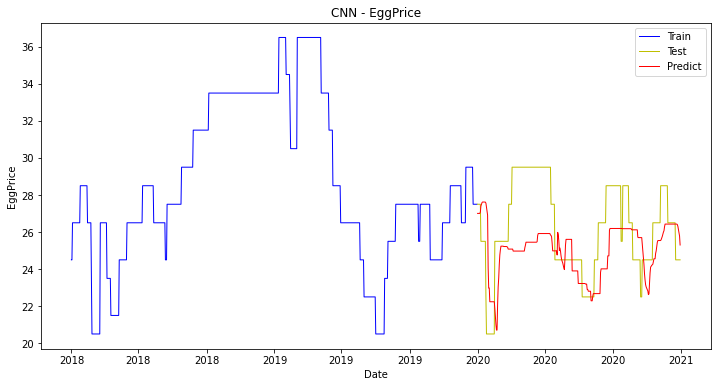

In [213]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)
TestPlot(output,730)

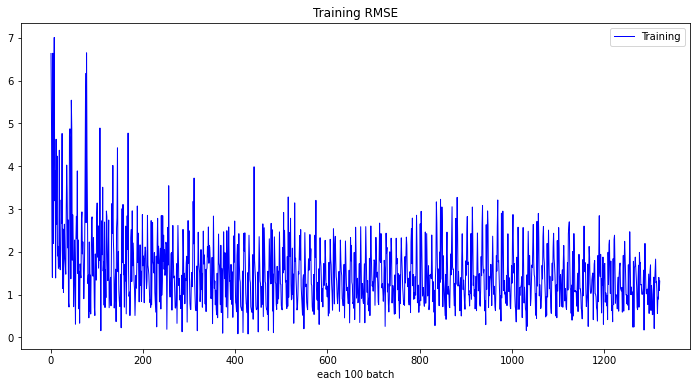

In [214]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))
trainingRMSE(train_RMSE)

### 預測 2021 蛋價 windowsize = 30, step = 1,  time_unit = day
#### 修改價格 Normalize, 資料一次看前30天預測下1天
#### lr = 0.01

In [215]:
# choose a number of time steps
n_windows = 30
n_steps = 1
# convert into input/output
# 資料只取到 2021
dataset_ar = oridata[:][:1461]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences_w(dataset_ar, n_steps, n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365//n_steps)
trainsize

len of dataset:  1430


1065

In [216]:
### Test 2021 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1065, 30, 18) (1065, 1)
Test data shape:  (365, 30, 18) (365, 1)


In [217]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [218]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [17:52<00:00,  5.59it/s]


best_step_cnt:  77700
best_tra_rmse:  tensor(0.0756, device='cuda:0', grad_fn=<SqrtBackward0>)


In [219]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)


 Test MSE: tensor(15.1138, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(3.8876, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0168, device='cuda:0', grad_fn=<DivBackward0>)


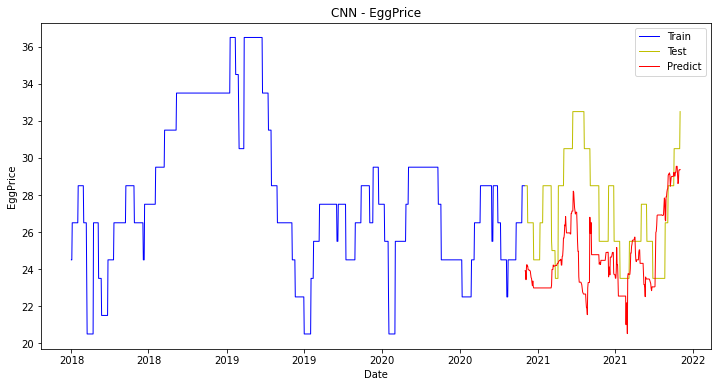

In [220]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)
TestPlot(output,1066)

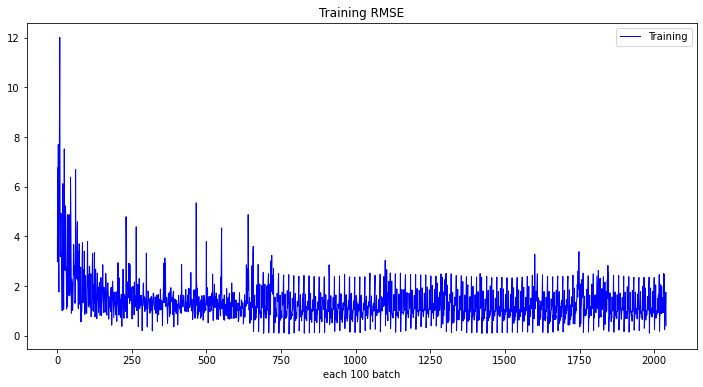

In [221]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))
trainingRMSE(train_RMSE)

### 預測 2022 蛋價 windowsize = 30, step = 1,  time_unit = day
#### 修改價格 Normalize, 資料一次看前30天預測下1天
#### lr = 0.01

In [223]:
# choose a number of time steps
n_windows = 30
n_steps = 1
# convert into input/output
# 資料取到 2022
dataset_ar = oridata[:][:]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences_w(dataset_ar, n_steps, n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365//n_steps)
trainsize

len of dataset:  1795


1430

In [224]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1430, 30, 18) (1430, 1)
Test data shape:  (365, 30, 18) (365, 1)


In [225]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [226]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [23:32<00:00,  4.25it/s]

best_step_cnt:  217900
best_tra_rmse:  tensor(0.0795, device='cuda:0', grad_fn=<SqrtBackward0>)


In [227]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)


 Test MSE: tensor(20.4726, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(4.5247, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0123, device='cuda:0', grad_fn=<DivBackward0>)


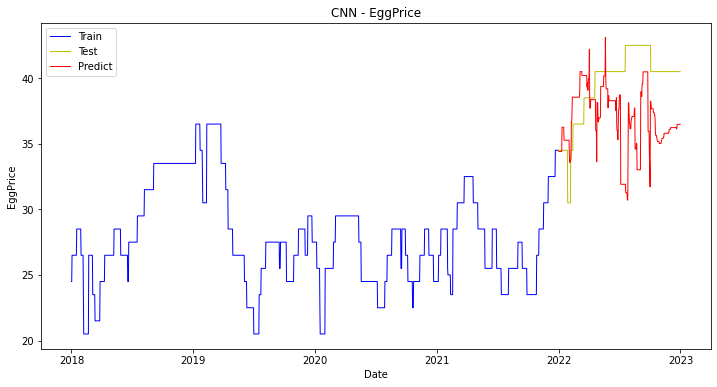

In [229]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)
TestPlot(output,1461)

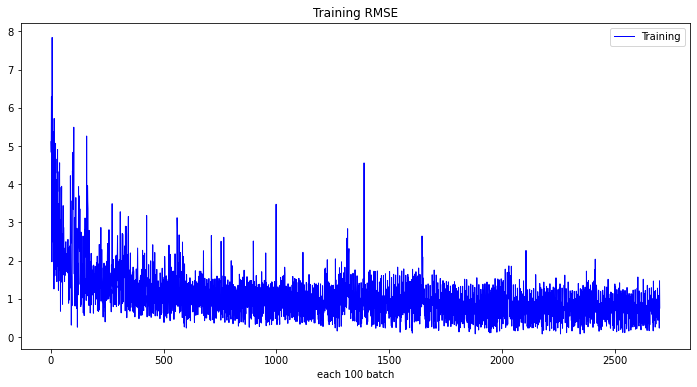

In [230]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))
trainingRMSE(train_RMSE)

### 預測 2020 蛋價 windowsize = 30, step = 1,  time_unit = day
#### 資料有增加, 價格 Normalize, 一次看前30天預測下1天
#### lr = 0.01

In [269]:
# choose a number of time steps
n_windows = 30
n_steps = 1
# convert into input/output
# 資料只取到 2020
dataset_ar = oridata_ex[:][:915]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences_w(dataset_ar, n_steps, n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365//n_steps)
trainsize

len of dataset:  884


519

In [270]:
### Test 2020 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (519, 30, 96) (519, 1)
Test data shape:  (365, 30, 96) (365, 1)


In [271]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [272]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [08:55<00:00, 11.19it/s]


best_step_cnt:  76500
best_tra_rmse:  tensor(0.0413, device='cuda:0', grad_fn=<SqrtBackward0>)


In [273]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)


 Test MSE: tensor(6.6895, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(2.5864, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)


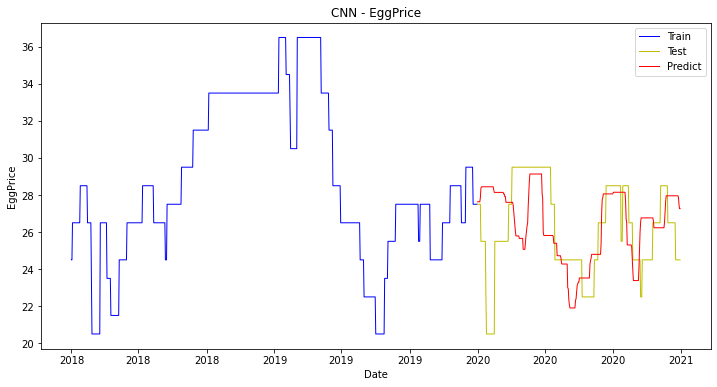

In [274]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)
TestPlot(output,730)

### 預測 2021 蛋價 windowsize = 30, step = 1,  time_unit = day
#### 資料有增加, 價格 Normalize, 一次看前30天預測下1天
#### lr = 0.01

In [276]:
# choose a number of time steps
n_windows = 30
n_steps = 1
# convert into input/output
# 資料只取到 2021
dataset_ar = oridata_ex[:][:1280]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences_w(dataset_ar, n_steps, n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365//n_steps)
trainsize

len of dataset:  1249


884

In [277]:
### Test 2021 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (884, 30, 96) (884, 1)
Test data shape:  (365, 30, 96) (365, 1)


In [278]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [279]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [14:48<00:00,  6.76it/s]

best_step_cnt:  98200
best_tra_rmse:  tensor(0.0099, device='cuda:0', grad_fn=<SqrtBackward0>)


In [280]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)


 Test MSE: tensor(14.3581, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(3.7892, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0190, device='cuda:0', grad_fn=<DivBackward0>)


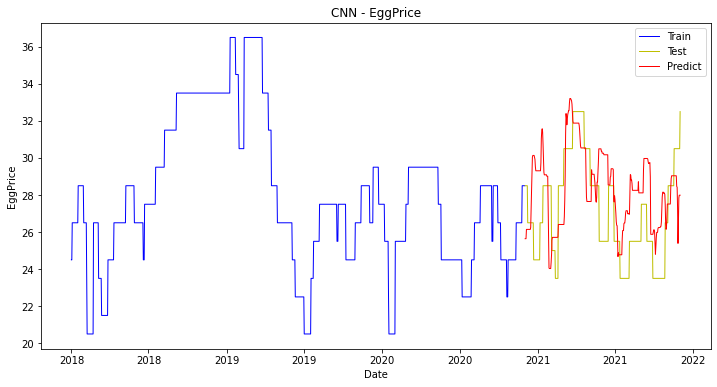

In [281]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)
TestPlot(output,1066)

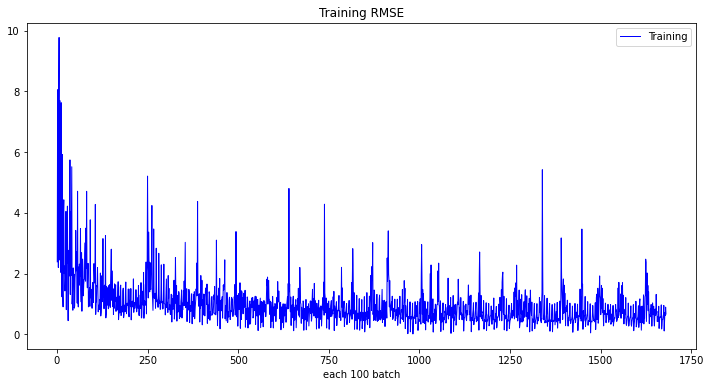

In [282]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))
trainingRMSE(train_RMSE)

### 預測 2022 蛋價 windowsize = 30, step = 1,  time_unit = day
#### 資料有增加, 價格 Normalize, 一次看前30天預測下1天
#### lr = 0.01

In [291]:
# choose a number of time steps
n_windows = 30
n_steps = 1
# convert into input/output
# 資料只取到 2022
dataset_ar = oridata_ex[:][:]
dataset_ar = np.array(dataset_ar)
dataset_x, dataset_y = split_sequences_w(dataset_ar, n_steps, n_windows)

print("len of dataset: ", len(dataset_x))
trainsize = len(dataset_x)-(365//n_steps)
trainsize

len of dataset:  1614


1249

In [292]:
### Test 2022 的情況

Train_x = dataset_x[0:trainsize].astype('float32')
Train_y = dataset_y[0:trainsize].astype('float32')
Test_x = dataset_x[trainsize:].astype('float32')
Test_y = dataset_y[trainsize:].astype('float32')

print("Train data shape: ",  Train_x.shape, Train_y.shape)
print("Test data shape: ",  Test_x.shape, Test_y.shape)

Train data shape:  (1249, 30, 96) (1249, 1)
Test data shape:  (365, 30, 96) (365, 1)


In [293]:
Trainset = TensorDataset(torch.from_numpy(Train_x), torch.from_numpy(Train_y))
Testset = TensorDataset(torch.from_numpy(Test_x), torch.from_numpy(Test_y))
trainloader = DataLoader(Trainset, batch_size=32, shuffle=False, num_workers=0)
testloader = DataLoader(Testset, batch_size=32, shuffle=False, num_workers=0)

In [294]:
n_features = Train_x.shape[2]
# import train

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 6000

### train

best_step_cnt, best_tra_rmse, train_rmse_list, output_list = train(trainloader, model, optimizer, epochs)

print("best_step_cnt: ",best_step_cnt)
print("best_tra_rmse: ",best_tra_rmse)

100%|██████████| 6000/6000 [19:26<00:00,  5.14it/s]

best_step_cnt:  70600
best_tra_rmse:  tensor(0.0005, device='cuda:0', grad_fn=<SqrtBackward0>)


In [295]:
# Test
model = torch.load('best_model.pt')
model.eval()
MSE_test, RMSE_test, MSPE_test,outputlist = test(testloader, model)
print("\n","Test MSE:", MSE_test)
print("Test RMSE:", RMSE_test)
print("Test MSPE:", MSPE_test)


 Test MSE: tensor(28.4799, device='cuda:0', grad_fn=<DivBackward0>)
Test RMSE: tensor(5.3367, device='cuda:0', grad_fn=<SqrtBackward0>)
Test MSPE: tensor(0.0169, device='cuda:0', grad_fn=<DivBackward0>)


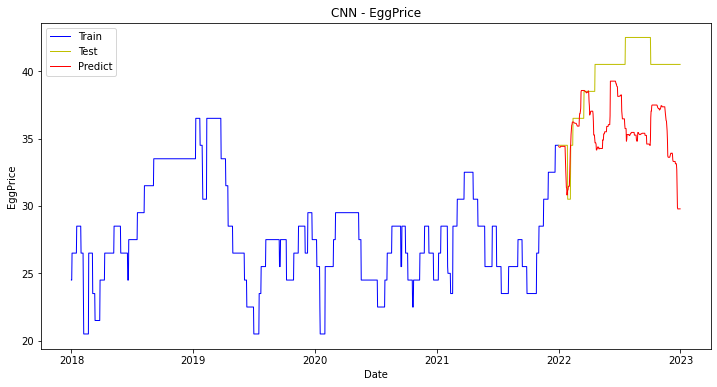

In [296]:
output = []
for i in outputlist:
  for j in i:
    j = float(j)
    output.append(j)
TestPlot(output,1461)

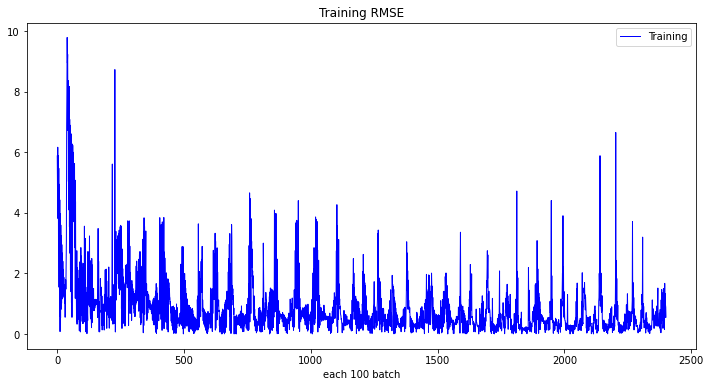

In [297]:
train_RMSE = []
for i in train_rmse_list:
  train_RMSE.append(float(i))
trainingRMSE(train_RMSE)